In [16]:
from __future__ import absolute_import
from __future__ import print_function
#from future.standard_library import install_aliases
#install_aliases()
import numpy as np
import os
import gzip
import struct
import array
import math
import matplotlib.pyplot as plt
import matplotlib.image
from urllib.request import urlretrieve
import tensorflow as tf
from tensorflow.python.framework import ops
from PIL import Image
from scipy import ndimage
%matplotlib inline
np.random.seed(1)

In [17]:
def download(url,filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file=os.path.join('data',filename)
    if not os.path.isfile(out_file):
        urlretrieve(url,out_file)

In [18]:
def mnist():
    base_url='http://yann.lecun.com/exdb/mnist/'

    def parse_labels(filename):
        with gzip.open(filename,'rb') as fh:
            magic,num_data=struct.unpack(">II",fh.read(8))
            return np.array(array.array("B",fh.read()),dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename,'rb') as fh:
            magic,num_data,rows,cols=struct.unpack(">IIII",fh.read(16))
            return np.array(array.array("B",fh.read()),dtype=np.uint8).reshape(num_data,rows,cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url+filename,filename)

    train_images=parse_images('data/train-images-idx3-ubyte.gz')
    train_labels=parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images=parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels=parse_labels('data/t10k-labels-idx1-ubyte.gz')

    return train_images,train_labels,test_images,test_labels

In [19]:
def load_mnist():
    partial_flatten=lambda x:np.reshape(x,(x.shape[0],np.prod(x.shape[1:])))
    one_hot=lambda x,k:np.array(x[:,None]==np.arange(k)[None,:],dtype=int)
    train_images,train_labels,test_images,test_labels=mnist()
    train_images=train_images/255.0
    test_images=test_images /255.0
    train_labels=one_hot(train_labels,10)
    test_labels=one_hot(test_labels,10)
    N_data=train_images.shape[0]

    return N_data,train_images,train_labels,test_images,test_labels

In [20]:
def plot_images(images,ax,ims_per_row=5,padding=5,digit_dimensions=(28,28),
                cmap=matplotlib.cm.binary,vmin=None,vmax=None):

    N_images=images.shape[0]
    N_rows=np.int32(np.ceil(float(N_images)/ims_per_row))
    pad_value=np.min(images.ravel())
    concat_images=np.full(((digit_dimensions[0]+padding)*N_rows+padding,
                             (digit_dimensions[1]+padding)*ims_per_row+padding),pad_value)
    for i in range(N_images):
        cur_image=np.reshape(images[i,:],digit_dimensions)
        row_ix=i // ims_per_row
        col_ix=i%ims_per_row
        row_start=padding+(padding+digit_dimensions[0])*row_ix
        col_start=padding+(padding+digit_dimensions[1])*col_ix
        concat_images[row_start:row_start+digit_dimensions[0],
                      col_start:col_start+digit_dimensions[1]]=cur_image
    cax=ax.matshow(concat_images,cmap=cmap,vmin=vmin,vmax=vmax)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    return cax

In [21]:
def plot_weight(imagetouse,parameter):
    init=tf.global_variables_initializer()
    X,Y=create_placeholder(28,28,1,10)
    Z2,Z3=forward_propagation(X,parameter)
    sess=tf.Session()
    sess.run(init)
    units=sess.run(Z2,feed_dict={X:imagetouse})
    filters=units.shape[3]
    plt.figure(1,figsize=(20,20))
    n_columns=6
    n_rows=math.ceil(filters/n_columns)+1
    for i in range(filters):
        plt.subplot(n_rows,n_columns,i+1)
        plt.title('Filter '+str(i))
        plt.imshow(units[0,:,:,i],interpolation="nearest",cmap="gray")

In [22]:
def create_placeholder(n_h,n_w,n_c,n_y):
    X=tf.placeholder(tf.float32,(None,n_h,n_w,n_c))
    Y=tf.placeholder(tf.float32,(None,n_y))
    return X,Y

In [23]:
def parameter_initialize():
    tf.set_random_seed(1)
    W1=tf.get_variable("W1",[5,5,1,32],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2=tf.get_variable("W2",[5,5,32,64],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameter={
        "W1":W1,
        "W2":W2
    }
    return parameter

In [24]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    m=X.shape[0]
    mini_batches=[]
    np.random.seed(seed)
    permutation=list(np.random.permutation(m))
    shuffled_X=X[permutation,:,:,]
    shuffled_Y=Y[permutation,:]
    num_complete_minibatches=math.floor(m/mini_batch_size)
    for k in range(0,num_complete_minibatches):
        mini_batch_X=shuffled_X[k*mini_batch_size:k*mini_batch_size+mini_batch_size,:,:,]
        mini_batch_Y=shuffled_Y[k*mini_batch_size:k*mini_batch_size+mini_batch_size,:]
        mini_batch=(mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    if m%mini_batch_size!=0:
        mini_batch_X=shuffled_X[num_complete_minibatches*mini_batch_size:m,:,:,]
        mini_batch_Y=shuffled_Y[num_complete_minibatches*mini_batch_size:m,:]
        mini_batch=(mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [25]:
def forward_propagation(X,parameter):
    W1=parameter['W1']
    W2=parameter['W2']
    
    Z1=tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding="SAME")
    A1=tf.nn.relu(Z1)
    P1=tf.nn.max_pool(A1,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")
    
    Z2=tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding="SAME")
    A2=tf.nn.relu(Z2)
    P2=tf.nn.max_pool(A2,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")
    
    P3=tf.contrib.layers.flatten(P2)
    P4=tf.contrib.layers.fully_connected(P3,1024,activation_fn=None)
    #P5=tf.nn.dropout(P4,keep_prob=.5)
    Z3=tf.contrib.layers.fully_connected(P4,10,activation_fn=None)
    
    return Z2,Z3

In [26]:
def compute_cost(Z3,Y):
    
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    return cost

In [27]:
def cnn_model(train_X,train_Y,test_X,test_Y,learning_rate=0.01,num_epochs=3,minibatch_size=256,print_cost=True):
    
    ops.reset_default_graph() 
    tf.set_random_seed(1)
    seed=3
    m,n_h,n_w,n_c=train_X.shape
    n_y=train_Y.shape[1]
    costs=[]
    
    X,Y=create_placeholder(n_h,n_w,n_c,n_y)
    parameter=parameter_initialize()
    Z2,Z3=forward_propagation(X,parameter)
    cost=compute_cost(Z3,Y)
    
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init=tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost=0
            #_,running_cost=sess.run([optimizer,cost],feed_dict={X:train_X,Y:train_Y})
            num_minibatches=int(m/minibatch_size)
            seed+=1
            minibatches=random_mini_batches(train_X,train_Y,minibatch_size,seed)
            for minibatch in minibatches:
                (minibatch_X,minibatch_Y)=minibatch
                _,running_cost=sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                minibatch_cost+=running_cost/num_minibatches
            if print_cost==True and epoch%5==0:
                print("Cost after epoch %i: %f" % (epoch,minibatch_cost))
            if print_cost==True and epoch%1==0:
                costs.append(minibatch_cost)

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        prediction_op=tf.argmax(Z3,1)
        correct_prediction=tf.equal(prediction_op,tf.argmax(Y,1))
        accuracy=tf.reduce_mean(tf.cast(correct_prediction,"float"))
        print(accuracy)
        train_accuracy=accuracy.eval({X:train_X,Y:train_Y})
        test_accuracy=accuracy.eval({X:test_X,Y:test_Y})
        print(train_accuracy)
        print(test_accuracy)

        return train_accuracy,test_accuracy,parameter

In [28]:
m,train_X,train_Y,test_X,test_Y=load_mnist()
train_X=np.reshape(train_X,(train_X.shape[0],train_X.shape[1],train_X.shape[2],1))
test_X=np.reshape(test_X,(test_X.shape[0],test_X.shape[1],test_X.shape[2],1))

In [29]:
print("number of training examples : "+str(train_X.shape[0]))
print("number of test examples : "+str(test_X.shape[0]))
print("train_X shape : "+str(train_X.shape))
print("train_Y shape : "+str(train_Y.shape))
print("test_X shape : "+str(test_X.shape))
print("test_Y shape : "+str(test_Y.shape))

number of training examples : 60000
number of test examples : 10000
train_X shape : (60000, 28, 28, 1)
train_Y shape : (60000, 10)
test_X shape : (10000, 28, 28, 1)
test_Y shape : (10000, 10)


Cost after epoch 0: 0.140330
Cost after epoch 5: 0.014447
Cost after epoch 10: 0.010225
Cost after epoch 15: 0.004997
Cost after epoch 20: 0.005606
Cost after epoch 25: 0.003868
Cost after epoch 30: 0.003447
Cost after epoch 35: 0.011057
Cost after epoch 40: 0.007065
Cost after epoch 45: 0.005264
Cost after epoch 50: 0.005559
Cost after epoch 55: 0.008510
Cost after epoch 60: 0.003932
Cost after epoch 65: 0.004544
Cost after epoch 70: 0.004535
Cost after epoch 75: 0.006937
Cost after epoch 80: 0.005182
Cost after epoch 85: 0.003030
Cost after epoch 90: 0.008256
Cost after epoch 95: 0.003233


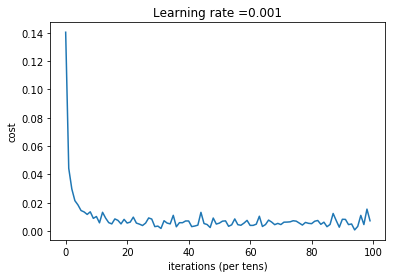

Tensor("Mean_1:0", shape=(), dtype=float32)
0.9997
0.9913


In [30]:
train_X=train_X[0:50000,:,:,]
train_Y=train_Y[0:50000,:]
_,_,parameter=cnn_model(train_X,train_Y,test_X,test_Y,learning_rate=0.001,num_epochs=100,minibatch_size=128,print_cost=True)

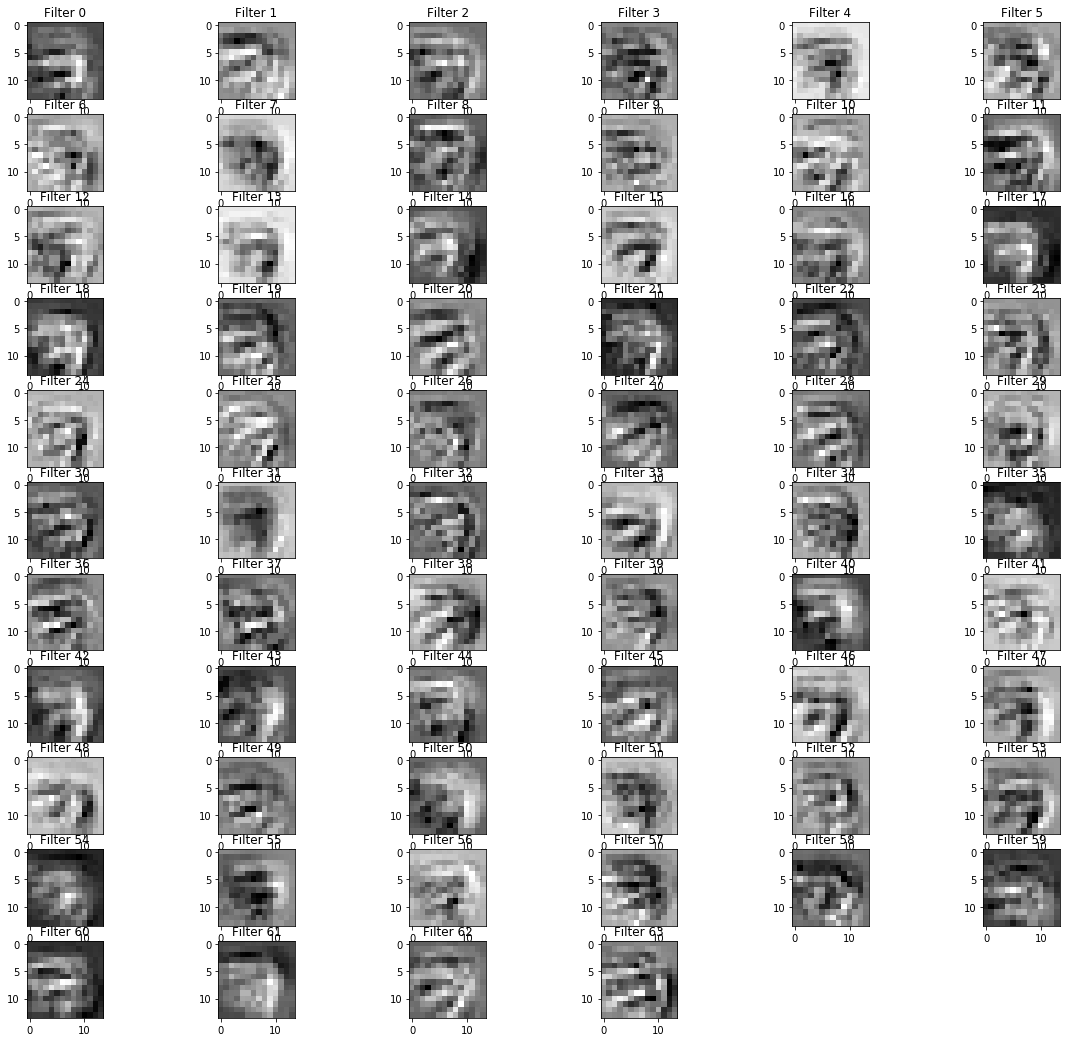

In [33]:
imagetouse=train_X[5000:5001,:,:,]
plot_weight(imagetouse,parameter)